# Baseline LSTM



Zuerst werden die Embeddings in ein DataFrame eingelesen. Später kann man selber ein LSTM Modell trainieren oder unsere vortranierten einlesen. Dabei ist es wichtig, dass das Datenset mit dem jeweiligen LSTM Modell übereinstimmen.

Es gibt drei Modelle und Datensätze:
- Embedding auf nicht übersetzten Daten
- Embedding auf übersetzten Daten
- Embedding mit vortrainiertem Word2Vec

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import accuracy_score
from torch.optim import Adam
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader

In [2]:
#DataFrames mit den nicht übersetzten Daten
PATH = 'data_lstm/'

In [3]:
#DataFrames mit den übersetzten Daten
PATH = 'data_lstm/en'

In [4]:
#DataFrames mit den übersetzen Daten auf einem vortrainierten Word2Vec
PATH = 'data_lstm/en/pretrained'

In [5]:
#Die gewählten Daten müssen mit dem gewählten Modell übereinstimmen

In [6]:
torch.set_printoptions(precision=20)

In [7]:
X_train = pd.read_pickle(os.path.join(PATH, 'X_train.pkl'))
y_train = np.load(os.path.join(PATH, 'y_train.npy'))
X_test = pd.read_pickle(os.path.join(PATH, 'X_test.pkl'))
X_validation = pd.read_pickle(os.path.join(PATH, 'X_val.pkl'))
y_validation = np.load(os.path.join(PATH, 'y_val.npy'))

In [8]:
y_train

array([0, 2, 0, ..., 2, 2, 0], dtype=int64)

In [9]:
X_train.head()

,premises,hypothesis
0,"[[0.038466, -0.039792, 0.082747, -0.38923, -0....","[[-0.2868, -0.34066, -0.30916, 0.14525, -0.200..."
1,"[[-0.23589, 0.3831, 0.10834, -0.063118, 0.0315...","[[-0.12724, 0.27224, -0.055019, -0.0030393, -0..."
2,"[[0.055707, -0.19015, -0.047215, 0.1475, -0.05...","[[0.065573, 0.022011, -0.13182, -0.2133, -0.04..."
3,"[[-0.28427, 0.047977, -0.15062, 0.019418, -0.1...","[[0.044694, 0.25695, -0.35741, 0.22959, 0.0605..."
4,"[[-0.44399, 0.12817, -0.25247, -0.18582, -0.16...","[[-0.41542, 0.077196, -0.28246, 0.071125, -0.1..."


In [10]:
X_train.shape

(10908, 2)

In [11]:
#Wir schauen uns die Längsten Sequenzen an. Das wird im Padding gebraucht

In [12]:
print(max(X_train.premises.apply(len)))
print(max(X_train.hypothesis.apply(len)))
print(max(X_validation.premises.apply(len)))
print(max(X_validation.hypothesis.apply(len)))
print(max(X_test.premises.apply(len)))
print(max(X_test.hypothesis.apply(len)))

204
196
202
118
204
196


In [13]:
#Die DataFrames werden gespeichert. Batches können geholt werden mit Tensors inklusive Padding

In [14]:
class NLIDataset(Dataset):
  def __init__(self, X, y):
        self.X = X
        self.y = torch.tensor(y,dtype=torch.float32)

  def __len__(self):
        return len(self.y)

  def __getitem__(self, index):
        X_batch_premises = self.X.iloc[index, 0]
        X_batch_hypothesis = self.X.iloc[index, 1]
        y_batch = self.y[index].type(torch.long)
        X_batch_premise_len = len(X_batch_premises)
        X_batch_hypothesis_len = len(X_batch_hypothesis)
        if X_batch_premises.ndim != 2 or X_batch_hypothesis.ndim != 2:
          return torch.zeros((205, 300), dtype=torch.float32), torch.zeros((197, 300), dtype=torch.float32), y_batch, X_batch_premise_len, X_batch_hypothesis_len
        pad_len_premises = 205 - X_batch_premise_len
        pad_len_hypothesis = 197 - X_batch_hypothesis_len
        X_batch_premises_tensor = torch.nn.functional.pad(torch.tensor(X_batch_premises, dtype=torch.float32), pad=(0, 0, 0, pad_len_premises))
        X_batch_hypothesis_tensor = torch.nn.functional.pad(torch.tensor(X_batch_hypothesis, dtype=torch.float32), pad=(0, 0, 0, pad_len_hypothesis))
        return X_batch_premises_tensor, X_batch_hypothesis_tensor, y_batch, X_batch_premise_len, X_batch_hypothesis_len

In [15]:
#Da wir die Paddings nicht ins LSTM einlesen möchten, kürzen wir die Tensoren individuell. Wir können die Sequenzen zwar nicht mehr in einem Tensor speichern, jedoch nun in einer Liste. 
#Das ist zwar nihct so ideal, jedoch funktioniert es.

In [16]:
def nested_tensor(X_batch_premises, X_batch_hypothesis, X_batch_premise_len, X_batch_hypothesis_len):
  batch_size = len(X_batch_premises)
  tensors_premises = []
  tensors_hypothesis = []
  for i in range(batch_size):
    tensors_premises.append(X_batch_premises[i][:int(X_batch_premise_len[i])])
    tensors_hypothesis.append(X_batch_hypothesis[i][:int(X_batch_hypothesis_len[i])])
  return tensors_premises, tensors_hypothesis

In [17]:
# Das Modell mit LSTMCell, Classificator und Softmax-Aktivierungsfunktion

In [18]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.lstm = nn.LSTMCell(input_size, hidden_size)
        self.classificator = nn.Linear(4 * hidden_size, 3)
        self.softmax = nn.Softmax(dim=-1)

    #die Sequenzen werden nacheinander abgearbeitet. Der Hidden State immer neu initialisiert
    #der letzte hidden State einer Sequenz (Prämisse oder Hypothese) wird gespeichert
    def _forward(self, batch_premises, batch_hypothesis, h, c):
        hidden_premises = []
        hidden_hypothesis = []
        for premises, hypothesis in zip(batch_premises, batch_hypothesis):
          hx = h
          cx = c
          for word in premises:
              hx, cx = self.lstm(word, (hx, cx))
          hidden_premises.append(hx)
          hx = h
          cx = c
          for word in hypothesis:
              hx, cx = self.lstm(word, (hx, cx))
          hidden_hypothesis.append(hx)
        hidden_premises_tensor = torch.stack(hidden_premises)
        hidden_hypothesis_tensor = torch.stack(hidden_hypothesis)
        return hidden_premises_tensor, hidden_hypothesis_tensor
            
    #Die letzten hidden states werden zusammengeführt und miteinander berechnet
    #Der neue Vektor wird in den Classificator eingelesen
    def forward(self, X_batch_premises, X_batch_hypothesis, h, c):
      hidden_premises, hidden_hypothesis = self._forward(X_batch_premises, X_batch_hypothesis, h, c)
      hidden_classificator = []
      for h_premises, h_hypothesis in zip(hidden_premises, hidden_hypothesis):
        concat_vector = []
        h_diff = h_premises - h_hypothesis
        h_multi = h_premises * h_hypothesis 
        concat_vector.extend(h_premises)
        concat_vector.extend(h_hypothesis)
        concat_vector.extend(h_diff)
        concat_vector.extend(h_multi)
        hidden_classificator.append(torch.tensor(concat_vector))
      hidden_classificator_tensor = torch.stack(hidden_classificator)
      output = self.classificator(hidden_classificator_tensor)
      output = self.softmax(output)
      y_pred = []
      for i in output:
        y_pred.append(torch.argmax(i).item())
      return output, torch.tensor(y_pred)

In [19]:
# Hyperparameters
input_size = 300
hidden_size = 100

Checkpoints.
Hier kann man vortrainierte Modelle einlesen

In [20]:
#Model auf nicht übersetzen Daten mit eigenem Word2Vec. Hidden_state=100
model = torch.load('model_lstm/model_own_100.pt')

In [21]:
#Model auf übersetzen Daten mit eigenem Word2Vec. Hidden_state=100
model = torch.load('model_lstm/model_en_own_100.pt')

In [22]:
#Model auf übersetzen Daten mit vortrainiertem Word2Vec. Hidden_state=100
model = torch.load('model_lstm/model_en_pretrained_100.pt')

Training

In [91]:
model = LSTMModel(input_size, hidden_size)

In [92]:
training_set = NLIDataset(X_train, y_train)
training_generator = DataLoader(training_set, batch_size=4, shuffle=False)

In [93]:
validation_set = NLIDataset(X_validation, y_validation)
validation_generator = DataLoader(validation_set, batch_size=1212, shuffle=False)

In [94]:
validation_accuracies = []

train_losses = []
training_accuracies = []

In [95]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.01)

In [101]:
num_epochs=10
model.train()

LSTMModel(
  (lstm): LSTMCell(300, 100)
  (classificator): Linear(in_features=400, out_features=3, bias=True)
  (softmax): Softmax(dim=-1)
)

In [102]:
for i in tqdm(range(num_epochs)):
  train_loss = .0
  train_acc = .0
  for X_batch_premises, X_batch_hypothesis, y_batch, X_batch_premises_len, X_batch_hypothesis_len in training_generator:
    X_batch_premises, X_batch_hypothesis = nested_tensor(X_batch_premises, X_batch_hypothesis, X_batch_premises_len, X_batch_hypothesis_len)
    optimizer.zero_grad()
    h0 = torch.zeros((hidden_size), dtype=torch.float32)
    c0 = torch.zeros((hidden_size), dtype=torch.float32)
    output, y_pred = model(X_batch_premises, X_batch_hypothesis, h0, c0)

    equals = torch.eq(y_pred, y_batch)
    train_acc += torch.mean(equals.type(torch.float)).item()
    loss = criterion(output, y_batch)

    train_loss += criterion(output, y_batch).item()
    loss.backward()
    optimizer.step()

  train_losses.append(train_loss/len(training_generator))
  training_accuracies.append(train_acc/len(training_generator))

  h0 = torch.zeros((hidden_size), dtype=torch.float32)
  c0 = torch.zeros((hidden_size), dtype=torch.float32)

  for X_batch_premises_val, X_batch_hypothesis_val, y_batch_val, X_batch_premises_len_var, X_batch_hypothesis_len_var in validation_generator:
    X_batch_premises_val, X_batch_hypothesis_val = nested_tensor(X_batch_premises_val, X_batch_hypothesis_val, X_batch_premises_len_var, X_batch_hypothesis_len_var)
    pred_output, y_pred_val = model(X_batch_premises_val, X_batch_hypothesis_val, h0, c0)
  
  val_accuracy = sklearn.metrics.accuracy_score(y_validation, y_pred_val)
  validation_accuracies.append(val_accuracy)
        
  print("Epoch: {}/{}".format(i+1, num_epochs),
     "Training accuracy: {:.3f}".format(train_acc/len(training_generator)),
     "Training loss: {:.3f}".format(train_loss/len(training_generator)),
     "Validation accuracy: {:.3f}".format(val_accuracy))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10 Training accuracy: 0.444 Training loss: 1.075 Validation accuracy: 0.384
Epoch: 2/10 Training accuracy: 0.444 Training loss: 1.075 Validation accuracy: 0.385
Epoch: 3/10 Training accuracy: 0.443 Training loss: 1.075 Validation accuracy: 0.384
Epoch: 4/10 Training accuracy: 0.444 Training loss: 1.075 Validation accuracy: 0.384
Epoch: 5/10 Training accuracy: 0.445 Training loss: 1.074 Validation accuracy: 0.384
Epoch: 6/10 Training accuracy: 0.445 Training loss: 1.074 Validation accuracy: 0.388
Epoch: 7/10 Training accuracy: 0.447 Training loss: 1.074 Validation accuracy: 0.391
Epoch: 8/10 Training accuracy: 0.448 Training loss: 1.074 Validation accuracy: 0.389
Epoch: 9/10 Training accuracy: 0.449 Training loss: 1.073 Validation accuracy: 0.391
Epoch: 10/10 Training accuracy: 0.451 Training loss: 1.073 Validation accuracy: 0.390


Evaluation auf dem Validierungsset

In [13]:
model.eval()

LSTMModel(
  (lstm): LSTMCell(300, 100)
  (classificator): Linear(in_features=400, out_features=3, bias=True)
  (softmax): Softmax(dim=-1)
)

In [14]:
h0 = torch.zeros((hidden_size), dtype=torch.float32)
c0 = torch.zeros((hidden_size), dtype=torch.float32)

In [15]:
validation_set = NLIDataset(X_validation, y_validation)
validation_generator = DataLoader(validation_set, batch_size=1212, shuffle=False)

In [16]:
for X_batch_premises_val, X_batch_hypothesis_val, y_batch_val, X_batch_premises_len_var, X_batch_hypothesis_len_var in validation_generator:
  X_batch_premises_val, X_batch_hypothesis_val = nested_tensor(X_batch_premises_val, X_batch_hypothesis_val, X_batch_premises_len_var, X_batch_hypothesis_len_var)
  pred_output, y_pred = model(X_batch_premises_val, X_batch_hypothesis_val, h0, c0)

In [17]:
accuracy = sklearn.metrics.accuracy_score(y_validation, y_pred)
f1 = sklearn.metrics.f1_score(y_validation, y_pred, average='macro')

In [18]:
print(accuracy)
print(f1)

0.3572607260726073
0.3451039937544638


In [78]:
conf_matrix = sklearn.metrics.confusion_matrix(y_validation, y_pred)

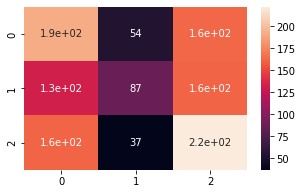

In [79]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(conf_matrix, index = [i for i in range(3)], columns = [i for i in range(3)])
plt.figure(figsize = (5,3))
sn.heatmap(df_cm, annot=True)

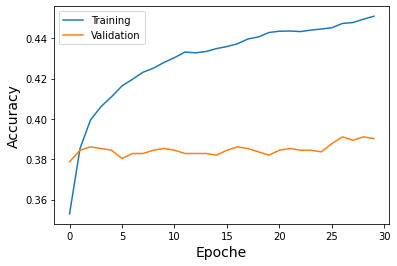

In [103]:
plt.plot(training_accuracies, label='Training')
plt.plot(validation_accuracies, label='Validation')
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoche', fontsize=14)
plt.legend()
plt.show() 

In [90]:
#torch.save(model, 'model_lstm/model.pt')

Auf dem Testset für die Abgabe

In [47]:
#Fake y_test für dataloader
y_test = np.zeros([5195])
y_test

array([0., 0., 0., ..., 0., 0., 0.])

In [48]:
test_set = NLIDataset(X_test, y_test)
test_generator = DataLoader(test_set, batch_size=5195, shuffle=False)

In [49]:
h0 = torch.zeros((hidden_size), dtype=torch.float32)
c0 = torch.zeros((hidden_size), dtype=torch.float32)

In [50]:
for X_batch_premises_test, X_batch_hypothesis_test, y_batch_test, X_batch_premises_len_test, X_batch_hypothesis_len_test in test_generator:
  X_batch_premises_test, X_batch_hypothesis_test = nested_tensor(X_batch_premises_test, X_batch_hypothesis_test, X_batch_premises_len_test, X_batch_hypothesis_len_test)
  pred_output, y_pred = model(X_batch_premises_test, X_batch_hypothesis_test, h0, c0)

In [51]:
submission = pd.read_csv('data_lstm/sample_submission.csv')

In [52]:
submission.prediction = y_pred

In [53]:
submission.to_csv('data_lstm/abgabe/schluss_pretrained_100.csv', index=False)